In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from sklearn import preprocessing
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import time
import random
from datetime import datetime, timedelta

In [ ]:
df1 = pd.read_csv("ambient_temperature_system_failure.csv")
df1.tail()

,timestamp,value
7262,2014-05-28 11:00:00,72.370206
7263,2014-05-28 12:00:00,72.172956
7264,2014-05-28 13:00:00,72.046565
7265,2014-05-28 14:00:00,71.825226
7266,2014-05-28 15:00:00,72.584089


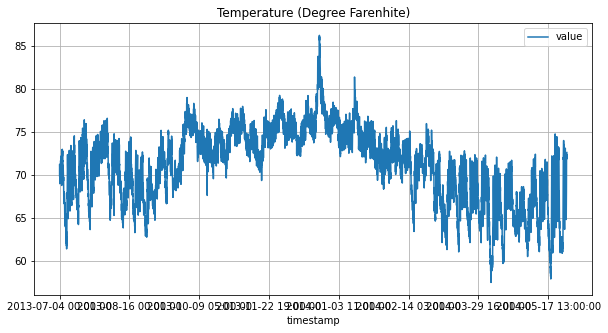

,timestamp,value
7266,2014-05-28 15:00:00,72.584089


In [ ]:
figsize=(10,5)
df1.plot(x='timestamp', y='value', figsize=figsize, title='Temperature (Degree Farenhite)');
plt.grid();
plt.show();
df1.tail(1)

In [ ]:
def updatecsv():
  dt_1 = str(df1.iloc[-1].timestamp)
  t = df1.iloc[-1].value
  print(dt_1)
  dt_2 = datetime(int(dt_1[0:4]), int(dt_1[5:7]), int(dt_1[8:10]), int(dt_1[11:13]), int(dt_1[14:16]), int(dt_1[17:19]))
  print(dt_2)
  result_2 = dt_2 + timedelta(minutes=1)
  df1.loc[len(df.index)] = [result_2, t + random.uniform(-3, +1.5)]
  df1.to_csv('/content/ambient_temperature_system_failure.csv')
  df1.tail(5)

In [ ]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

In [ ]:
def retrainmodel():
  figsize = (10,5)
  df = pd.read_csv("ambient_temperature_system_failure.csv");
  df['timestamp'] = pd.to_datetime(df['timestamp'])
  df['value'] = (df['value'] - 32) * 5/9
  df.plot(x='timestamp', y='value', figsize=figsize)
  plt.title('Temperature (Degree Celcius)', fontsize=16)
  plt.grid()
  plt.show()
  df['hours'] = df['timestamp'].dt.hour
  df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int) 
  df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
  df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
  outliers_fraction = 0.01
  df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
  df['categories'] = df['WeekDay']*2 + df['daylight']
  a = df.loc[df['categories'] == 0, 'value']
  b = df.loc[df['categories'] == 1, 'value']
  c = df.loc[df['categories'] == 2, 'value']
  d = df.loc[df['categories'] == 3, 'value']
  print(a , b, c, d)
  figsize=(10,5)
  fig, ax = plt.subplots(figsize=figsize)
  a_heights, a_bins = np.histogram(a)
  b_heights, b_bins = np.histogram(b, bins=a_bins)
  c_heights, c_bins = np.histogram(c, bins=a_bins)
  d_heights, d_bins = np.histogram(d, bins=a_bins)
  width = (a_bins[1] - a_bins[0])/6
  ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='Weekend Night')
  ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='Weekend Light')
  ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='Weekday Night')
  ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='Weekday Light')
  plt.legend()
  plt.show()
  data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
  min_max_scaler = preprocessing.StandardScaler()
  np_scaled = min_max_scaler.fit_transform(data_n)
  data_n = pd.DataFrame(np_scaled)
  #Important parameters and training/Test size
  prediction_time = 1 
  testdatasize = 1000
  unroll_length = 50
  testdatacut = testdatasize + unroll_length  + 1
  #Training data
  x_train = data_n[0:-prediction_time-testdatacut].values
  y_train = data_n[prediction_time:-testdatacut  ][0].values
  #Test data
  x_test = data_n[0-testdatacut:-prediction_time].values
  y_test = data_n[prediction_time-testdatacut:  ][0].values
  x_train = unroll(x_train,unroll_length)
  x_test  = unroll(x_test,unroll_length)
  y_train = y_train[-x_train.shape[0]:]
  y_test  = y_test[-x_test.shape[0]:]
  model = Sequential()
  model.add(LSTM(input_dim=x_train.shape[-1], units=50, return_sequences=True))
  model.add(Dropout(0.2))

  model.add(LSTM(100, return_sequences=False))
  model.add(Dropout(0.2))

  model.add(Dense(units=1))
  model.add(Activation('linear'))

  start = time.time()
  model.compile(loss='mse', optimizer='rmsprop')
  print('compilation time : {}'.format(time.time() - start))
  model.fit(x_train, y_train, batch_size=3028, epochs=10, validation_split=0.1)
  return model,x_test,y_test,data_n,df

In [ ]:
def detectoutlier(loaded_model,data_n,df):
  diff=[]
  ratio=[]
  p = loaded_model.predict(x_test)
  for u in range(len(y_test)):
      pr = p[u][0]
      ratio.append((y_test[u]/pr)-1)
      diff.append(abs(y_test[u]- pr))
  plt.figure(figsize = (10, 5))
  plt.plot(p,color='red', label='Prediction')
  plt.plot(y_test,color='blue', label='Test Data')
  plt.legend(loc='upper left')
  plt.grid()
  plt.legend()
  #Pick the most distant prediction/reality data points as anomalies
  diff = pd.Series(diff)
  number_of_outliers = int(0.01*len(diff))
  print(number_of_outliers)
  threshold = diff.nlargest(number_of_outliers).min()
  print(threshold)
  #Data with anomaly label
  test = (diff >= threshold).astype(int)
  testdatasize = 1000
  complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
  df['anomaly27'] = complement.append(test, ignore_index='True')
  print(df['anomaly27'].value_counts())
  #Visualizing anomalies (Red Dots)
  plt.figure(figsize=(15,10))
  a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly
  plt.plot(df['time_epoch'], df['value'], color='blue')
  plt.scatter(a['time_epoch'],a['value'], color='red', label = 'Anomaly')
  plt.axis([1.370*1e7, 1.405*1e7, 15,30])
  plt.grid()
  plt.legend()
  df[df['anomaly27'] == 1]  

In [ ]:
t1 = datetime.now().isoformat(' ','seconds')

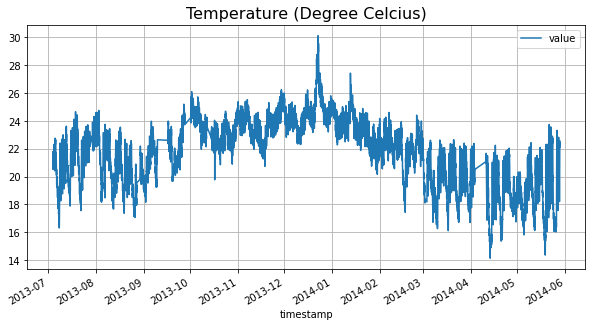

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  from ipykernel import kernelapp as app


48      22.017202
49      21.442631
50      21.584712
51      21.713760
52      21.581796
          ...    
7182    16.462841
7183    17.025287
7184    16.869787
7185    16.085735
7202    16.373580
Name: value, Length: 680, dtype: float64 55      21.071795
56      20.714305
57      20.959104
58      20.105613
59      20.509331
          ...    
7197    16.246925
7198    16.137000
7199    16.920085
7200    16.026475
7201    16.756677
Name: value, Length: 1344, dtype: float64 0       21.044908
1       21.789015
2       21.598781
3       20.533000
4       20.713084
          ...    
7253    19.182731
7254    19.809068
7255    18.746277
7256    19.022433
7257    18.213346
Name: value, Length: 1741, dtype: float64 7       20.760894
8       20.648174
9       20.547824
10      21.091701
11      21.420108
          ...    
7262    22.427892
7263    22.318309
7264    22.248092
7265    22.125126
7266    22.546716
Name: value, Length: 3502, dtype: float64


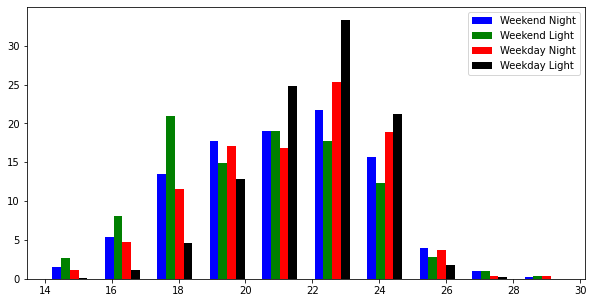

compilation time : 0.003367900848388672
Epoch 1/10
2/2 [==============================] - 7s 2s/step - loss: 0.6426 - val_loss: 0.6677
Epoch 2/10
2/2 [==============================] - 3s 2s/step - loss: 0.1836 - val_loss: 0.2946
Epoch 3/10
2/2 [==============================] - 3s 2s/step - loss: 0.1945 - val_loss: 0.2510
Epoch 4/10
2/2 [==============================] - 3s 2s/step - loss: 0.1131 - val_loss: 0.2371
Epoch 5/10
2/2 [==============================] - 3s 2s/step - loss: 0.1034 - val_loss: 0.2122
Epoch 6/10
2/2 [==============================] - 3s 2s/step - loss: 0.1121 - val_loss: 0.2040
Epoch 7/10
2/2 [==============================] - 3s 2s/step - loss: 0.1039 - val_loss: 0.1884
Epoch 8/10
2/2 [==============================] - 3s 2s/step - loss: 0.0893 - val_loss: 0.1752
Epoch 9/10
2/2 [==============================] - 3s 2s/step - loss: 0.0851 - val_loss: 0.1677
Epoch 10/10
32/32 [==============================] - 1s 14ms/step
10
1.3797827154770486
0    7257
1      

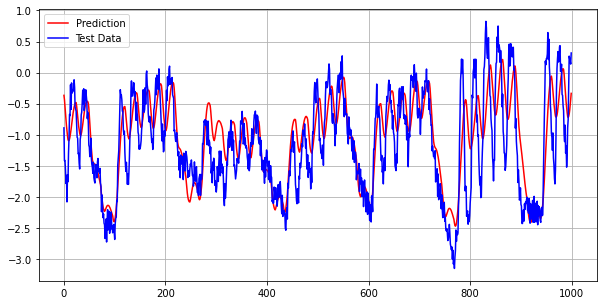

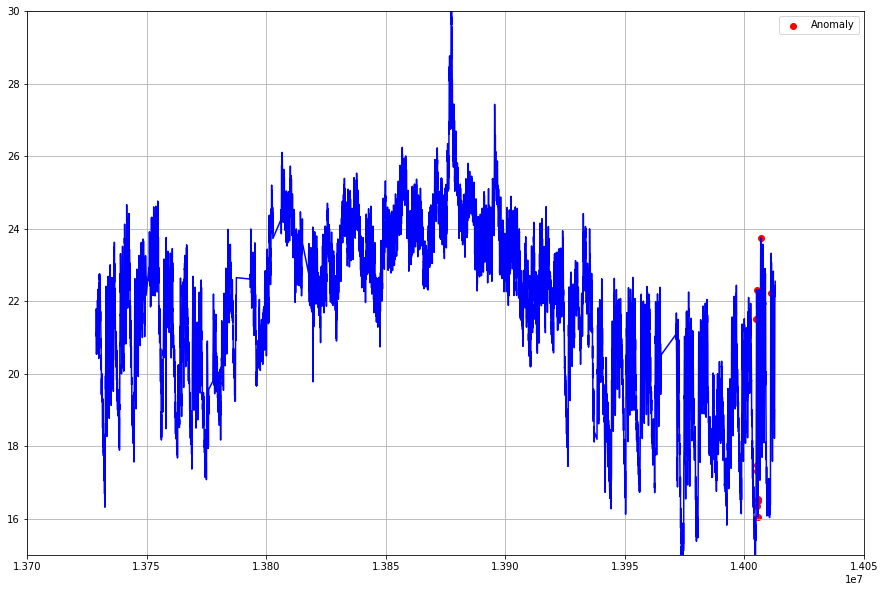

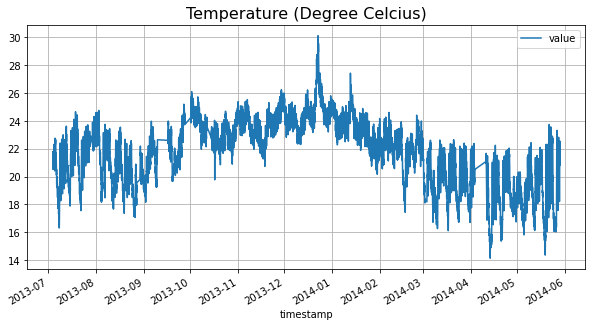

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  from ipykernel import kernelapp as app


48      22.017202
49      21.442631
50      21.584712
51      21.713760
52      21.581796
          ...    
7182    16.462841
7183    17.025287
7184    16.869787
7185    16.085735
7202    16.373580
Name: value, Length: 680, dtype: float64 55      21.071795
56      20.714305
57      20.959104
58      20.105613
59      20.509331
          ...    
7197    16.246925
7198    16.137000
7199    16.920085
7200    16.026475
7201    16.756677
Name: value, Length: 1344, dtype: float64 0       21.044908
1       21.789015
2       21.598781
3       20.533000
4       20.713084
          ...    
7253    19.182731
7254    19.809068
7255    18.746277
7256    19.022433
7257    18.213346
Name: value, Length: 1741, dtype: float64 7       20.760894
8       20.648174
9       20.547824
10      21.091701
11      21.420108
          ...    
7263    22.318309
7264    22.248092
7265    22.125126
7266    22.546716
7267    20.841611
Name: value, Length: 3503, dtype: float64


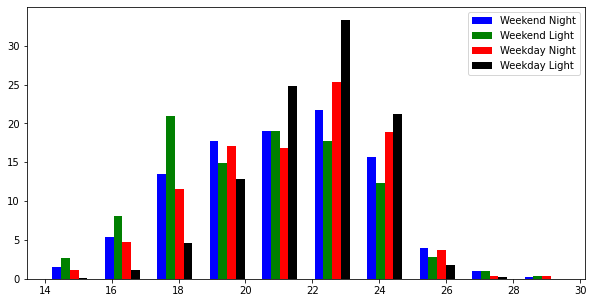

compilation time : 0.005086183547973633
Epoch 1/10
2/2 [==============================] - 9s 2s/step - loss: 0.6394 - val_loss: 0.8127
Epoch 2/10
2/2 [==============================] - 3s 2s/step - loss: 0.1978 - val_loss: 0.5230
Epoch 3/10
2/2 [==============================] - 3s 2s/step - loss: 0.1663 - val_loss: 0.2887
Epoch 4/10
2/2 [==============================] - 3s 2s/step - loss: 0.1316 - val_loss: 0.2968
Epoch 5/10
2/2 [==============================] - 3s 2s/step - loss: 0.1161 - val_loss: 0.2204
Epoch 6/10
2/2 [==============================] - 3s 2s/step - loss: 0.1009 - val_loss: 0.1850
Epoch 7/10
2/2 [==============================] - 3s 2s/step - loss: 0.1015 - val_loss: 0.1681
Epoch 8/10
2/2 [==============================] - 3s 2s/step - loss: 0.0952 - val_loss: 0.1569
Epoch 9/10
2/2 [==============================] - 3s 2s/step - loss: 0.0891 - val_loss: 0.1487
Epoch 10/10
32/32 [==============================] - 1s 15ms/step
10
1.2722538116023707
0    7258
1      

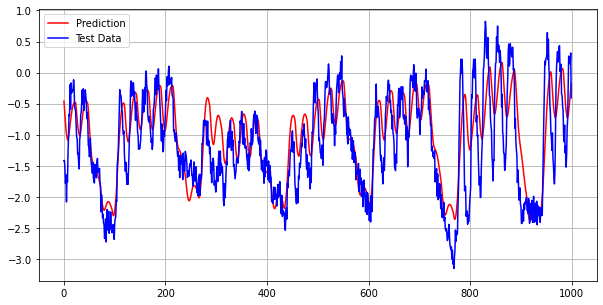

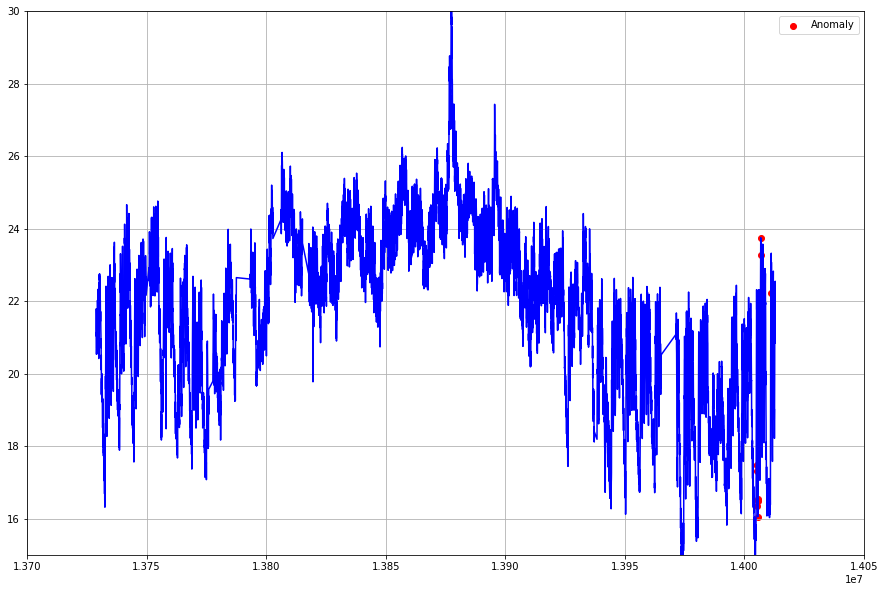

In [ ]:
count = 5
count1 = 0
while(True):
  t2 = datetime.now().isoformat(' ','seconds')
  temp1 = int(t1[14:16])
  temp2 = int(t2[14:16])
  if(count1 == 5):
    break
  if temp1 != temp2:
    temp1 = temp2
    print(temp1, temp2)
    updatecsv()
    count += 1
    count1 += 1
  if count == 5:
    count = 0
    loaded_model,x_test,y_test,data_n,df= retrainmodel()
    print(loaded_model)
    detectoutlier(loaded_model,data_n,df)

In [ ]:
df1.tail()

,timestamp,value
7263,2014-05-28 12:00:00,72.172956
7264,2014-05-28 13:00:00,72.046565
7265,2014-05-28 14:00:00,71.825226
7266,2014-05-28 15:00:00,72.584089
7267,2014-05-28 15:05:00,69.514901


In [ ]:
df.columns

Index(['Unnamed: 0', 'timestamp', 'value', 'hours', 'daylight', 'DayOfTheWeek',
       'WeekDay', 'time_epoch', 'categories', 'anomaly27'],
      dtype='object')

In [ ]:
df[df["anomaly27"] == 1]

,Unnamed: 0,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories,anomaly27
7057,7057,2014-05-19 22:00:00,17.314340,22,1,0,1,14005368,3,1
7058,7058,2014-05-19 23:00:00,17.486520,23,0,0,1,14005404,2,1
7059,7059,2014-05-20 00:00:00,17.482751,0,0,1,1,14005440,2,1
7060,7060,2014-05-20 01:00:00,16.349560,1,0,1,1,14005476,2,1
7061,7061,2014-05-20 02:00:00,16.487268,2,0,1,1,14005512,2,1
7062,7062,2014-05-20 03:00:00,16.548298,3,0,1,1,14005548,2,1
7063,7063,2014-05-20 04:00:00,16.047528,4,0,1,1,14005584,2,1
7097,7097,2014-05-21 14:00:00,23.280172,14,1,2,1,14006808,3,1
7098,7098,2014-05-21 15:00:00,23.747744,15,1,2,1,14006844,3,1
7215,7215,2014-05-26 12:00:00,22.237181,12,1,0,1,14011056,3,1
